In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [3]:

url = 'https://raw.githubusercontent.com/GoogleCloudPlatform/training-data-analyst/master/courses/ai-for-finance/data/AAPL10Y.csv'
df = pd.read_csv(url)


df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

print(df.shape)

df.head()

(2517, 5)


,close,volume,open,high,low
date,,,,,
2009-06-03,20.1357,140628992.0,20.0000,20.1586,19.8671
2009-06-04,20.5343,136628071.0,20.0186,20.5971,20.0057
2009-06-05,20.6671,157944127.0,20.7586,20.9143,20.4586
2009-06-08,20.5500,232466290.0,20.5457,20.6043,19.9186
2009-06-09,20.3886,168830811.0,20.5443,20.6514,20.0786


,weekly_ret
date,
2009-06-14,-0.016712
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027396
2009-07-12,-0.032905


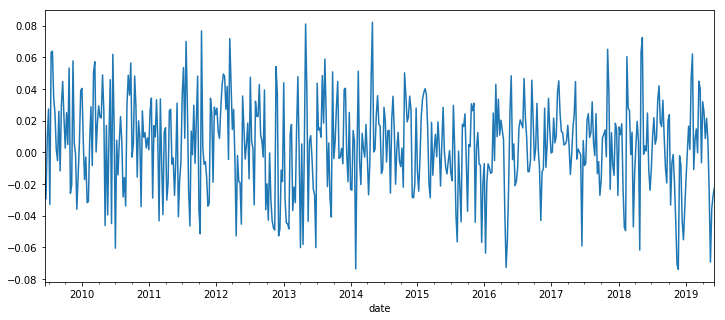

In [14]:
df_week = df.resample('w').mean()
df_week = df_week[['close']]
df_week.head()

df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.head()

# drop null rows
df_week.dropna(inplace=True)

df_week.weekly_ret.plot(kind='line', figsize=(12, 5));

udiff = df_week.drop(['close'], axis=1)
udiff.head()

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

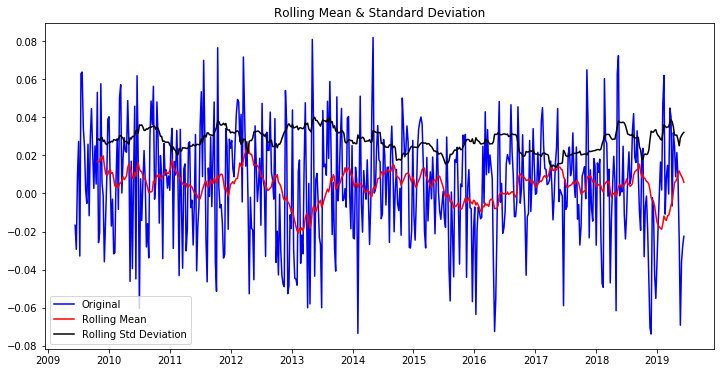

Test Statistic                -1.105002e+01
p-value                        5.107869e-20
#Lags Used                     2.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64

In [16]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

plt.figure(figsize=(12, 6))
orig = plt.plot(udiff, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput


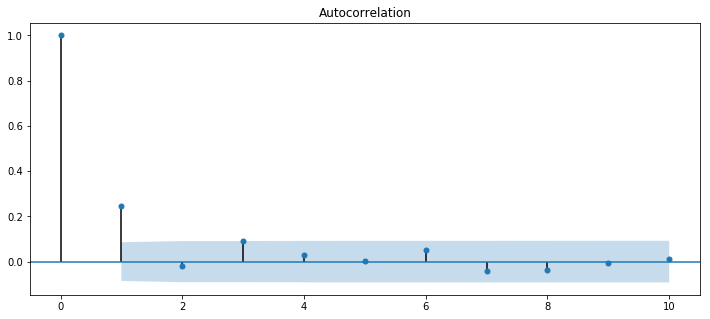

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff.values, lags=10, ax=ax)
plt.show()

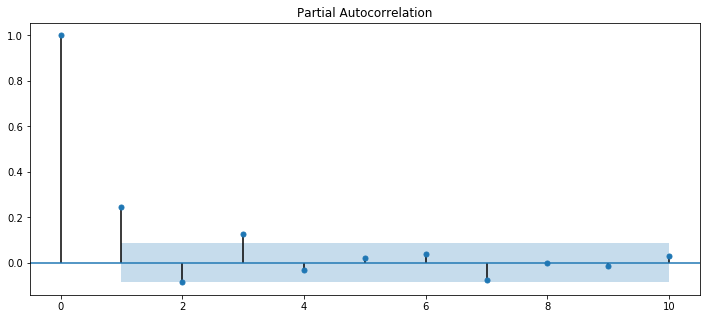

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff.values, lags=10, ax=ax)
plt.show()

In [9]:
from statsmodels.tsa.arima_model import ARMA

# Notice that you have to use udiff - the differenced data rather than the original data. 
ar1 = ARMA(tuple(udiff.values), (3, 1)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  522
Model:                     ARMA(3, 1)   Log Likelihood                1131.581
Method:                       css-mle   S.D. of innovations              0.028
Date:                Thu, 21 May 2020   AIC                          -2251.163
Time:                        10:00:40   BIC                          -2225.617
Sample:                             0   HQIC                         -2241.157
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.442      0.015       0.001       0.007
ar.L1.y        0.0601      0.264      0.227      0.820      -0.458       0.578
ar.L2.y       -0.0591      0.084     -0.705      0.481      -0.223       0.105
ar.L3.y        0.1080      0.053      2.049      0.041       0.005       0.211
ma.L1.y        0.2219      0.265      0.839      0.402      -0.297       0.740
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8278           -1.8757j            2.0502           -0.3161
AR.2           -0.8278           +1.8757j            2.0502            0.3161
AR.3            2.2031           -0.0000j            2.2031           -0.0000
MA.1           -4.5055           +0.0000j            4.5055            0.5000
-----------------------------------------------------------------------------
"""

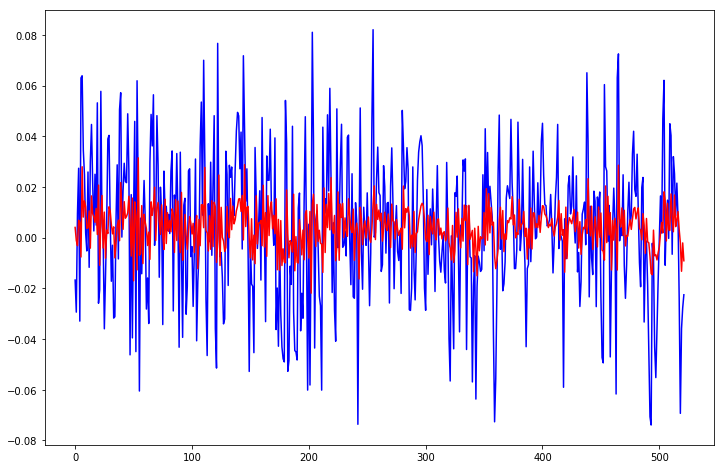

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

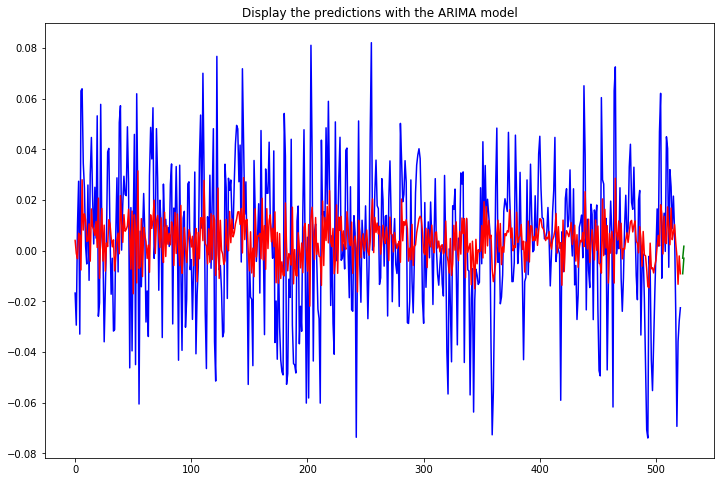

In [12]:
steps = 2

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff.values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff.values)+1, len(udiff.values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff.values)+1, len(udiff.values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()